**FIRST ATTEMP TO APPLY SSL TO THE SENTINEL-2 DATASET**

Reference tutorial: https://docs.lightly.ai/tutorials/package/tutorial_simsiam_esa.html

In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

***

***

# Imports

## Packages and modules

In [3]:
# Main.
import utils

# OS module.
import os

# PyTorch.
import torch
import torchvision
from torchinfo import summary

# Data management.
import numpy as np
import pandas as pd

# Lightly.
import lightly

# Training checks.
from datetime import datetime
import time
import copy
import math

from lightly.utils.debug import std_of_l2_normalized

# Showing images in the notebook.
import IPython

# For plotting.
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp
import seaborn as sns

# For resizing images to thumbnails.
import torchvision.transforms.functional as functional

# For clustering and 2d representations.
from sklearn import random_projection

## Settings

In [4]:
# Handling class imbalance.
handle_imb_classes = False

# Hyperparamenters.
exp = utils.Experiment(epochs=1,
                       batch_size=64)
output_dir_model = 'pytorch_models/'
print(exp.device)

cuda


In [5]:
# Dimension of the embeddings.
num_ftrs = 512

# Dimension of the output of the prediction and projection heads.
out_dim = proj_hidden_dim = 512

# The prediction head uses a bottleneck architecture.
pred_hidden_dim = 128

## Reproducibility

In [6]:
exp.reproducibility()

***

***

# Loading dataset

In [7]:
# List of trained models.
datasets_dir = 'datasets/'

# Get the subsets with full path.
data_dirs = utils.listdir_fullpath(datasets_dir)

# Leave out unwanted subsets (0_Raw and Clothing-dataset).
data_dirs = data_dirs[2:]
for dirs in data_dirs:
    print(dirs)

# Select the target dataset.
data_dir_target = data_dirs[1]
print('\nSelected: ' + data_dir_target)

# Ratio.
ratio = data_dir_target[
    data_dir_target.index("("):data_dir_target.index(")")+1
]
print(ratio)

# Load mean and std from file.
mean, std = utils.load_mean_std_values(data_dir_target)
print(mean)
print(std)

datasets/Sentinel2GlobalLULC-ratio=(0.010,0.2970,0.6930)-seed=42
datasets/Sentinel2GlobalLULC-ratio=(0.100,0.2700,0.6300)-seed=42
datasets/Sentinel2GlobalLULC-ratio=(0.300,0.2100,0.4900)-seed=42
datasets/Sentinel2GlobalLULC-ratio=(0.500,0.1500,0.3500)-seed=42
datasets/Sentinel2GlobalLULC-ratio=(0.700,0.0900,0.2100)-seed=42
datasets/Sentinel2GlobalLULC-ratio=(0.900,0.0300,0.0700)-seed=42
datasets/Sentinel2GlobalLULC-ratio=(0.990,0.0030,0.0070)-seed=42

Selected: datasets/Sentinel2GlobalLULC-ratio=(0.100,0.2700,0.6300)-seed=42
(0.100,0.2700,0.6300)
{'train': [0.3331, 0.3374, 0.3606], 'val': [0.3323, 0.3371, 0.3602], 'test': [0.3329, 0.3373, 0.3603]}
{'train': [0.2968, 0.237, 0.2112], 'val': [0.2973, 0.2376, 0.2113], 'test': [0.2978, 0.2377, 0.2116]}


## Custom tranforms (w/o normalization)

Define the augmentations for self-supervised learning.

In [8]:
# from https://github.com/facebookresearch/simsiam/blob/main/main_simsiam.py
import random
from PIL import ImageFilter


class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x


# MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    torchvision.transforms.RandomApply([
        torchvision.transforms.ColorJitter(.4, .4, .4, .1)  # not strengthened
    ], p=0.8),
    torchvision.transforms.RandomGrayscale(p=0.2),
    torchvision.transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean['train'], std['train'])
])

In [9]:
# # Data augmentations for the train dataset.
# train_transform = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((exp.input_size, exp.input_size)),
#     torchvision.transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
#     torchvision.transforms.RandomApply([
#             torchvision.transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
#         ], p=0.8),  # not strengthened
#     torchvision.transforms.RandomGrayscale(p=0.2),
#     # torchvision.transforms.RandomApply([
#     #     simsiam.loader.GaussianBlur([.1, 2.])
#     # ], p=0.5),
#     torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean['train'], std['train'])
# ])

# Data augmentations for the val and test datasets.
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((exp.input_size, exp.input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean['val'], std['val'])
])

# Data augmentations for the val and test datasets.
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((exp.input_size, exp.input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean['test'], std['test'])
])

## ImageFolder

In [10]:
# Loading the three datasets.
train_data = torchvision.datasets.ImageFolder(data_dir_target + '/train/')

val_data = torchvision.datasets.ImageFolder(data_dir_target + '/val/')

test_data = torchvision.datasets.ImageFolder(data_dir_target + '/test/')

# Building the lightly datasets from the PyTorch datasets.
train_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(train_data)

val_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(
    val_data,
    transform=val_transform
)

test_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(
    test_data,
    transform=test_transform
)

## Dealing with imbalanced data

In [11]:
if handle_imb_classes:

    # Creating a list of labels of samples.
    train_sample_labels = train_data.targets

    # Calculating the number of samples per label/class.
    class_sample_count = np.unique(train_sample_labels,
                                   return_counts=True)[1]
    print(class_sample_count)

    # Weight per sample not per class.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in train_sample_labels])

    # Casting.
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.double()

    # Sampler, imbalanced data.
    sampler = torch.utils.data.WeightedRandomSampler(
        samples_weight,
        len(samples_weight)
    )
    shuffle = False

else:
    sampler = None
    shuffle = True

print(f'Sampler: {sampler}')
print(f'Shuffle: {shuffle}')

Sampler: None
Shuffle: True


## Collate functions

PyTorch uses a Collate Function to combine the data in your batches together.

BaseCollateFunction (base class) takes a batch of images as input and <b>transforms each image into two different augmentations</b> with the help of random transforms. The images are then concatenated such that the output batch is exactly twice the length of the input batch.

In [12]:
# Base class for other collate implementations.
# This allows training.
collate_fn_train = lightly.data.collate.BaseCollateFunction(train_transform)

## PyTorch dataloaders

In [13]:
# Dataloader for training.
dataloader_train_simsiam = torch.utils.data.DataLoader(
    train_data_lightly,
    batch_size=exp.batch_size,
    shuffle=shuffle,
    collate_fn=collate_fn_train,
    drop_last=True,
    num_workers=exp.num_workers,
    worker_init_fn=exp.seed_worker,
    generator=exp.g,
    sampler=sampler
)

# Dataloader for embedding (val).
dataloader_val = torch.utils.data.DataLoader(
    val_data_lightly,
    batch_size=exp.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=exp.num_workers,
    worker_init_fn=exp.seed_worker,
    generator=exp.g
)

# Dataloader for embedding (test).
dataloader_test = torch.utils.data.DataLoader(
    test_data_lightly,
    batch_size=exp.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=exp.num_workers,
    worker_init_fn=exp.seed_worker,
    generator=exp.g
)

## Check the balance and size of the dataset

In [14]:
# Check samples per class in train dataset.
print(np.unique(train_data.targets, return_counts=True)[1])

[1400  465  886 1400 1193  443  134 1400 1043  638  288   56  125 1400
  391  387 1399   41   48  420 1400 1400 1400  200   84  102   35   41
 1259]


In [15]:
# Check samples per class in train dataset.
print(np.unique(val_data.targets, return_counts=True)[1])

[3780 1257 2394 3780 3222 1197  363 3780 2818 1722  777  153  339 3780
 1056 1045 3777  112  131 1135 3780 3780 3780  541  227  275   95  111
 3399]


In [16]:
# Check samples per class in test dataset.
print(np.unique(test_data.targets, return_counts=True)[1])

[8820 2934 5589 8820 7522 2797  851 8820 6577 4020 1815  358  794 8820
 2467 2440 8815  263  308 2650 8820 8820 8820 1263  531  643  223  261
 7932]


In [17]:
print('N batches in train dataset: ' + str(len(dataloader_train_simsiam)))

# Check the size of each dataset.
print(len(train_data.targets))
print(len(val_data.targets))
print(len(test_data.targets))

N batches in train dataset: 304
19478
52606
122793


## Check the distribution of samples in the dataloader (lightly dataset)

## Look at some samples (lightly dataset)

### Only one sample from the training batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])
torch.Size([64])


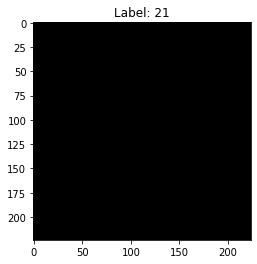

In [18]:
# Accessing Data and Targets in a PyTorch DataLoader.
for i, (images, labels, names) in enumerate(dataloader_train_simsiam):
    img = images[0][0]
    label = labels[0]
    print(images[0].shape)
    print(labels.shape)
    plt.title("Label: " + str(int(label)))
    plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.show()
    if i == 0:
        break  # Only a few batches.

### Two batches (almost)

Note: Comment out the normalization augmentation first to view the images below properly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

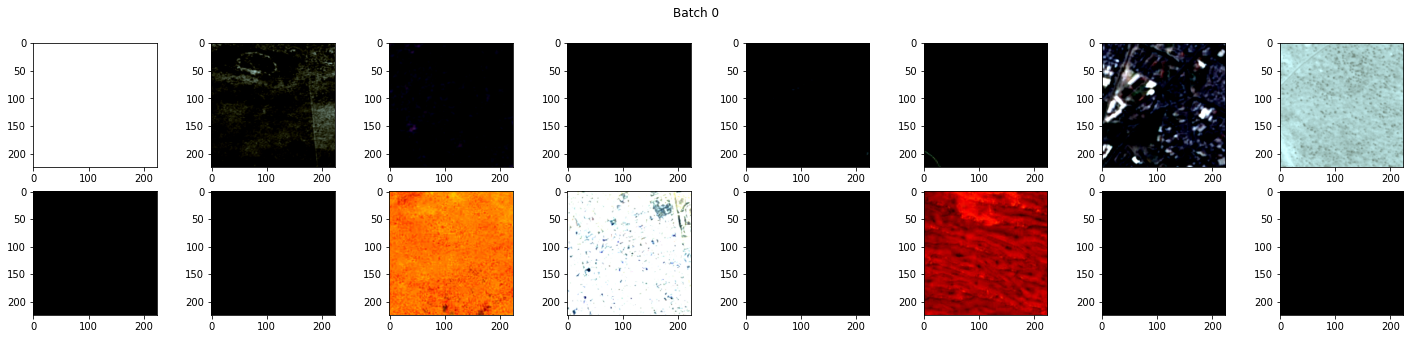

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

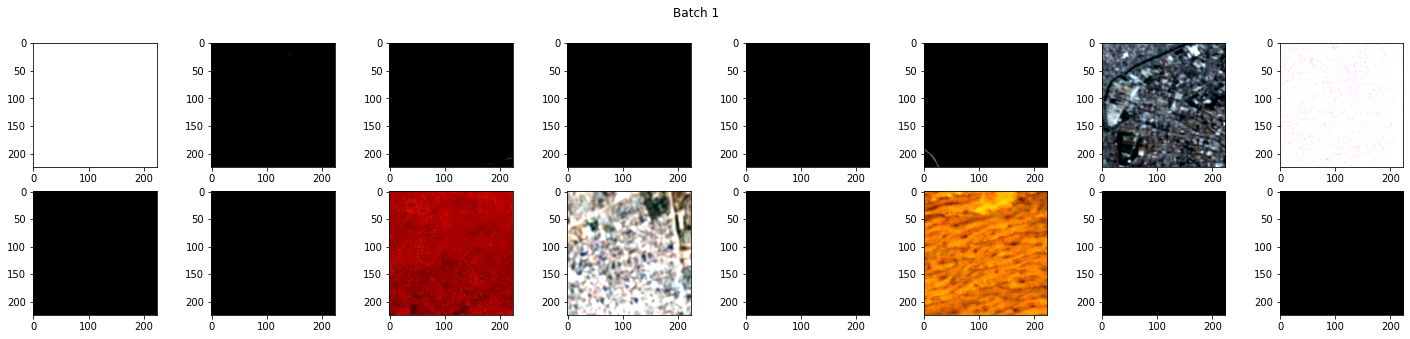

In [19]:
def show_batch(batch, batch_id):
    """
    Shows the images in the batch.

    Attributes:
        batch: Batch of images.
        batch_id: Batch identification number.
    """

    columns = 8
    rows = 2
    width = 25
    height = 5

    fig = plt.figure(figsize=(width, height))
    fig.suptitle(f'Batch {batch_id}')
    for i in range(1, columns * rows + 1):
        if i < exp.batch_size:
            img = batch[i]
            fig.add_subplot(rows, columns, i)
            plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.show()


# Train loop.
for b, ((x0, x1), _, _) in enumerate(dataloader_train_simsiam):

    # Show the images within each batch.
    show_batch(x0, 0)
    show_batch(x1, 1)
    break

Each image is augmented differently in the two batches that are loaded at the same time during training. The dataloader from lightly is capable of providing two batches in one iteration.

# Self-supervised models

In [20]:
model_name = 'simsiam'
root_dir = f'pytorch_models/{model_name}/'
output_dir_fig = f'figures/{model_name}/'

## Creation

In [21]:
from models import SimSiam, SimCLRModel, BarlowTwins

Copied from Lightly tutorials

## Backbone net (w/ ResNet18)

This is different from the tutorial: resnet without pretrained weights (not now).

In [22]:
# Resnet trained from scratch.
resnet = torchvision.models.resnet18(
    # weights=torchvision.models.ResNet18_Weights.DEFAULT
    weights=None
)

# Removing head from resnet. Embedding.
backbone = torch.nn.Sequential(*list(resnet.children())[:-1])

# Model creation.
if model_name == 'simsiam':
    model = SimSiam(backbone, num_ftrs, proj_hidden_dim,
                    pred_hidden_dim, out_dim)
elif model_name == 'simclr':
    hidden_dim = resnet.fc.in_features
    model = SimCLRModel(backbone, hidden_dim)
elif model_name == 'barlowtwins':
    model = BarlowTwins(backbone)

In [23]:
# Model's backbone structure.
summary(
    model.backbone,
    input_size=(exp.batch_size, 3, exp.input_size, exp.input_size),
    device=exp.device
)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 512, 1, 1]           --
├─Conv2d: 1-1                            [64, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        128
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]          --
│

## Training setup

SimSiam uses a symmetric negative cosine similarity loss and does therefore not require any negative samples. We build a criterion and an optimizer.



In [24]:
# Scale the learning rate.
# lr = 0.05 * exp.batch_size / 256
lr = 0.2

# Use SGD with momentum and weight decay.
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=1e-4
)

## Training

### Loop

In [25]:
# Device used for training.
print(f"Using {exp.device} device")
model.to(exp.device)

# Saving best model's weights.
# best_model_wts = copy.deepcopy(model.state_dict())
collapse_level = 0
lowest_loss = 10000

# ======================
# TRAINING LOOP.
# Iterating over the epochs.
for e in range(exp.epochs):

    # Timer added.
    t0 = time.time()

    # Training enabled.
    model.train()

    # ======================
    # DATALOADER LOOP.
    # Iterating through the dataloader (lightly dataset is different).
    running_train_loss = 0.
    for b, ((x0, x1), _, _) in enumerate(dataloader_train_simsiam):

        # Move images to the GPU (two batches).
        x0 = x0.to(exp.device)
        x1 = x1.to(exp.device)

        # Run the model on both transforms of the images:
        # We get projections (z0 and z1) and
        # predictions (p0 and p1) as output.
        if model_name == 'simsiam':
            z0, p0 = model(x0)
            z1, p1 = model(x1)
            loss = 0.5 * (model.criterion(z0, p1) + model.criterion(z1, p0))
        else:
            loss = model.training_step(x0, x1)

        # Averaged loss across all training examples * batch_size.
        running_train_loss += loss.item() * exp.batch_size

        # Run backpropagation.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if model_name == 'simsiam':
            model.check_collapse(p0, loss)

        # Show partial stats.
        if b % 250 == 249:
            print(f'T[{e}, {b + 1:5d}] | '
                  f'Running train loss: '
                  f'{running_train_loss/(b*exp.batch_size):.4f}')

    # ======================
    # LOSS.
    # Loss averaged across all training examples for the current epoch.
    epoch_train_loss = (running_train_loss
                        / len(dataloader_train_simsiam.sampler))

    # ======================
    # EVALUATION.
    # The evaluation process was not okey (it's been deleted).

    # The level of collapse is large if the standard deviation of
    # the l2 normalized output is much smaller than 1 / sqrt(dim).
    if model_name == 'simsiam':
        collapse_level = max(0., 1 - math.sqrt(out_dim) * model.avg_output_std)

    # ======================
    # SAVING CHECKPOINT.
    # Save model.
    save_model = (epoch_train_loss < lowest_loss) or (e == exp.epochs - 1)
    if save_model:

        # Update new lowest losses
        lowest_loss = epoch_train_loss

        # Move the model to CPU before saving
        # it and then back to the GPU.
        model.to('cpu')
        model.save(e,
                   epoch_train_loss,
                   handle_imb_classes,
                   ratio,
                   output_dir_model,
                   collapse_level=collapse_level)
        model.to(exp.device)

    # ======================
    # EPOCH STATISTICS.
    # Show some stats per epoch completed.
    print(f'[Epoch {e:3d}] | '
          f'Train loss: {epoch_train_loss:.4f} | '
          f'Duration: {(time.time()-t0):.2f} s | '
          f'Saved: {save_model} | '
          f'Collapse Level (SimSiam): {collapse_level:.4f}/1.0\n')

Using cuda device
T[0,   250] | Running train loss: -0.8022
[Epoch   0] | Train loss: -0.8091 | Duration: 68.29 s | Saved: True | Collapse Level (SimSiam): 0.3106/1.0



In [26]:
print(model)

simsiam_bb_resnet18-epoch=000-train_loss=-0.8091-coll=0.3106(0)-balanced=False-ratio=(0.100,0.2700,0.6300)-time=2023_01_16_19_49_34


Collapse level: the closer to zero the better

A value close to 0 indicates that the representations have collapsed. A value close to 1/sqrt(dimensions), where dimensions are the number of representation dimensions, indicates that the representations are stable. 

### Checking the weights of the last model

In [27]:
# First convolutional layer weights.
print(model.backbone[0])
print(model.backbone[0].weight[63])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
tensor([[[-0.0507,  0.0014, -0.0007, -0.0050, -0.0412, -0.0204,  0.0266],
         [-0.0065,  0.0105, -0.0323, -0.0088, -0.0322,  0.0188,  0.0093],
         [ 0.0132, -0.0068, -0.0014, -0.0217, -0.0114, -0.0490, -0.0139],
         [ 0.0438, -0.0542, -0.0084,  0.0048, -0.0108, -0.0138, -0.0728],
         [ 0.0011,  0.0102, -0.0239, -0.0103, -0.0359,  0.0053, -0.0261],
         [ 0.0268, -0.0187,  0.0140,  0.0195,  0.0101, -0.0137, -0.0115],
         [ 0.0110, -0.0109,  0.0032,  0.0321, -0.0556, -0.0147,  0.0443]],

        [[ 0.0178, -0.0286,  0.0088,  0.0371, -0.0036,  0.0514, -0.0188],
         [-0.0280,  0.0290,  0.0416,  0.0130,  0.0924,  0.0275,  0.0203],
         [ 0.0445,  0.0174, -0.0459, -0.0126,  0.0116, -0.0326, -0.0001],
         [ 0.0116,  0.0182, -0.0536, -0.0209,  0.0352,  0.0703,  0.0503],
         [ 0.0283,  0.0057,  0.0448,  0.0150,  0.0471, -0.0003,  0.0315],
         [ 0.0133, -0.0097, -0.01

***

***

# Reduce dimensionality

## Calculate embeddings

In [28]:
# Empty lists.
embeddings = []
labels = []

# Disable gradients for faster calculations.
# Put the model in evaluation mode.
model.eval()
with torch.no_grad():
    for i, (x, y, fnames) in enumerate(dataloader_val):

        # Move the images to the GPU.
        x = x.to(exp.device)
        y = y.to(exp.device)

        # Embed the images with the pre-trained backbone.
        emb = model.backbone(x).flatten(start_dim=1)

        # Store the embeddings and filenames in lists.
        embeddings.append(emb)
        labels.append(y)

# Concatenate the embeddings and convert to numpy.
embeddings = torch.cat(embeddings, dim=0).to('cpu').numpy()
labels = torch.cat(labels, dim=0).to('cpu').numpy()

# Show shapes.
print(np.shape(embeddings))
print(np.shape(labels))

(52606, 512)
(52606,)


# PCA

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

# t-SNE

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

***

***

# Check each model's performance/collapse on val data

In [29]:
def get_scatter_plot_with_thumbnails_axes(ax, title=''):
    """
    Creates a scatter plot with image overlays
    that are plotted in a particular ax position.

    """

    # Shuffle images and find out which images to show.
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:

        # Only show image if it is sufficiently far away from the others.
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # Plot image overlays.
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 2.5)  # 2.
        path = os.path.join(data_dir_test, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # Set aspect ratio.
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')
    ax.title.set_text(title)

datasets/Sentinel2GlobalLULC-ratio=(0.100,0.2700,0.6300)-seed=42/val/
00: simsiam_bb_resnet18-epoch=000-train_loss=-0.8091-coll=0.3106(0)-balanced=False-ratio=(0.100,0.2700,0.6300)-time=2023_01_16_19_42_27
01: simsiam_bb_resnet18-epoch=000-train_loss=-0.8091-coll=0.3106(0)-balanced=False-ratio=(0.100,0.2700,0.6300)-time=2023_01_16_19_49_34
pytorch_models/simsiam/simsiam_bb_resnet18-epoch=000-train_loss=-0.8091-coll=0.3106(0)-balanced=False-ratio=(0.100,0.2700,0.6300)-time=2023_01_16_19_42_27
42
129
pytorch_models/simsiam/simsiam_bb_resnet18-epoch=000-train_loss=-0.8091-coll=0.3106(0)-balanced=False-ratio=(0.100,0.2700,0.6300)-time=2023_01_16_19_49_34
42
129


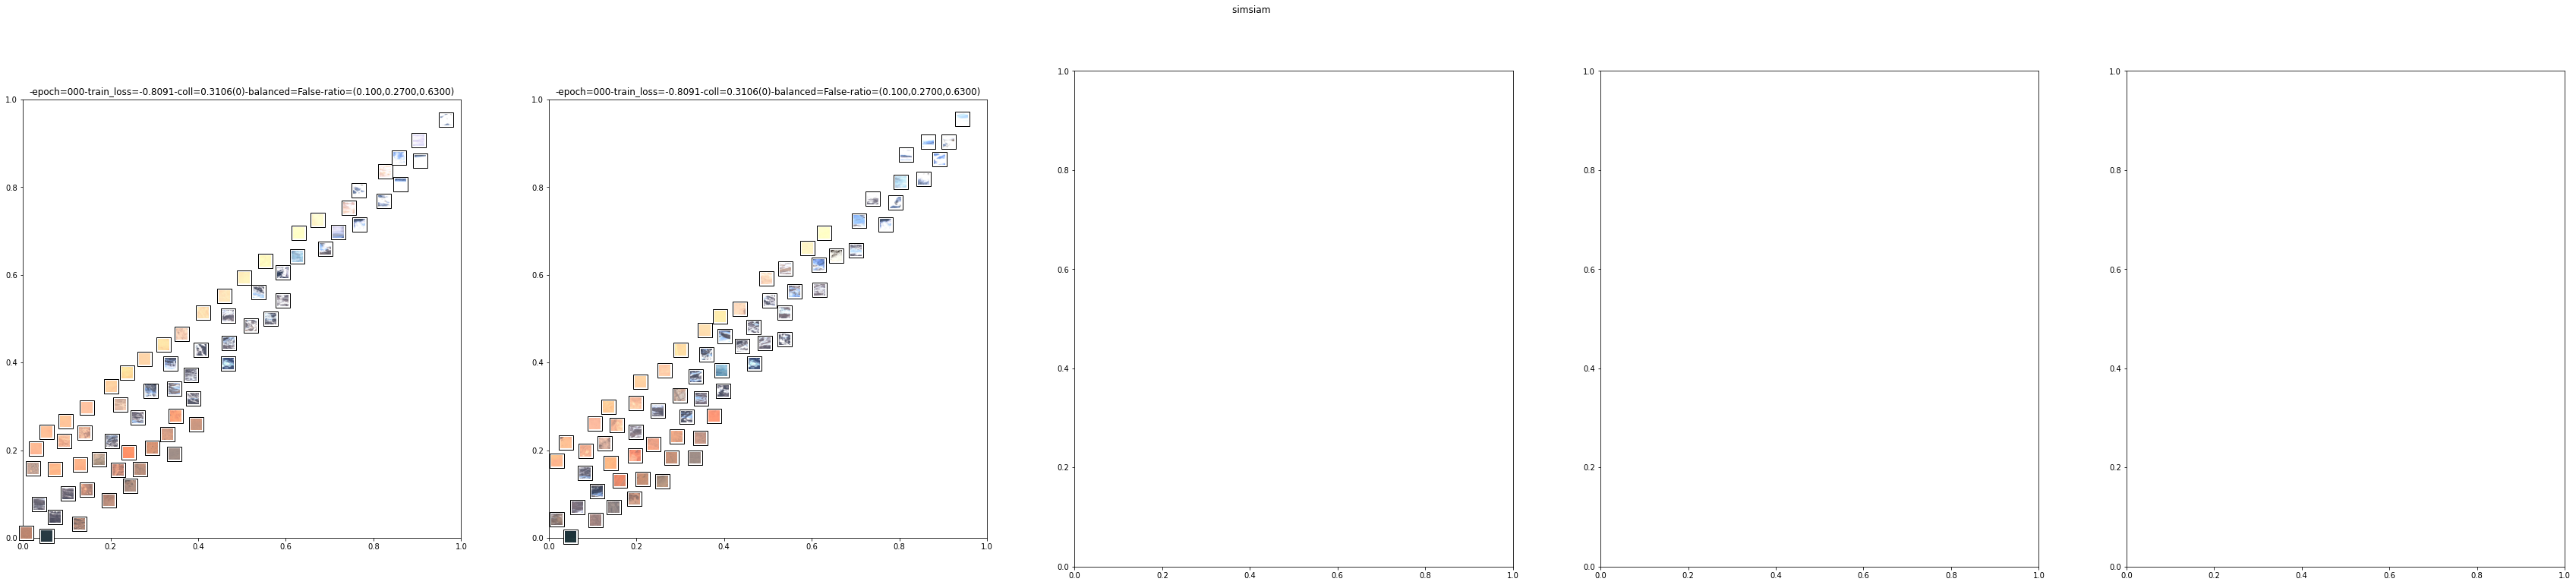

74:80: E501 line too long (97 > 79 characters)
83:80: E501 line too long (81 > 79 characters)


In [40]:
# Validation dataset.
data_dir_test = data_dir_target + '/val/'
print(data_dir_test)

# List of trained models.
model_list = []
for root, dirs, files in os.walk(root_dir):
    for i, filename in enumerate(sorted(files, reverse=False)):
        model_list.append(root + filename)
        print(f'{i:02}: {filename}')

# Plot setup.
ncols = 5
nrows = int(math.ceil(len(model_list) / ncols))

fig, axes = plt.subplots(nrows=nrows,
                         ncols=ncols,
                         figsize=(12*ncols, 12*nrows))

# Convert the array to 1 dimension.
axes = axes.ravel()

# Main loop over the models.
for model_id, model_name_local in enumerate(model_list):

    # Load model weights.
    model.backbone.load_state_dict(torch.load(model_name_local))

    # Empty lists.
    embeddings = []
    filenames = []

    # Disable gradients for faster calculations.
    # Put the model in evaluation mode.
    model.eval()
    with torch.no_grad():
        for i, (x, _, fnames) in enumerate(dataloader_val):

            # Move the images to the GPU.
            x = x.to(exp.device)

            # Embed the images with the pre-trained backbone.
            y = model.backbone(x).flatten(start_dim=1)

            # Store the embeddings and filenames in lists.
            embeddings.append(y)
            filenames = filenames + list(fnames)

    # Concatenate the embeddings and convert to numpy.
    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()

    # For the scatter plot we want to transform the images to a
    # 2-D vector space using a random Gaussian projection.
    projection = random_projection.GaussianRandomProjection(
        n_components=2,
        random_state=exp.seed
    )
    embeddings_2d = projection.fit_transform(embeddings)

    # Normalize the embeddings to fit in the [0, 1] square.
    M = np.max(embeddings_2d, axis=0)
    m = np.min(embeddings_2d, axis=0)
    embeddings_2d = (embeddings_2d - m) / (M - m)

    # Get a scatter plot with thumbnail overlays.
    start_chr_epoch = model_name_local.find('-epoch') + 1
    start_chr_time = model_name_local.find('-time')
    get_scatter_plot_with_thumbnails_axes(
        axes[model_id],
        title=model_name_local[start_chr_epoch:start_chr_time]
    )

    # Show progress.
    print(f'Subplot of model-{model_id} done!',
          end='\r',
          flush=True)

# Save figure.
fig.suptitle(f'{model_name}')
fig.savefig(f'{output_dir_fig}models_knn_{datetime.now():%Y_%m_%d_%H_%M_%S}.pdf',
            bbox_inches='tight')

***

***

# Embeddings for the samples of the test dataset

## Setup

In [31]:
# Test dataset.
data_dir_test = data_dir_target + '/test/'
print(data_dir_test)

datasets/Sentinel2GlobalLULC-ratio=(0.100,0.2700,0.6300)-seed=42/test/


In [32]:
# load best model weights
idx = 0
print(model_list[idx])
model.backbone.load_state_dict(torch.load(model_list[idx]))

pytorch_models/simsiam/simsiam_bb_resnet18-epoch=000-train_loss=-0.8091-coll=0.3106(0)-balanced=False-ratio=(0.100,0.2700,0.6300)-time=2023_01_16_19_42_27


<All keys matched successfully>

## Compute embeddings

In [33]:
# Empty lists.
embeddings = []
filenames = []

# Disable gradients for faster calculations.
# Put the model in evaluation mode.
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):

        # Move the images to the GPU.
        x = x.to(exp.device)

        # Embed the images with the pre-trained backbone.
        y = model.backbone(x).flatten(start_dim=1)

        # Store the embeddings and filenames in lists.
        embeddings.append(y)
        filenames = filenames + list(fnames)

# Concatenate the embeddings and convert to numpy.
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

## Projection to 2D space

In [34]:
# For the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection.
projection = random_projection.GaussianRandomProjection(
    n_components=2,
    random_state=exp.seed
)
embeddings_2d = projection.fit_transform(embeddings)

# Normalize the embeddings to fit in the [0, 1] square.
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

## Scatter plots

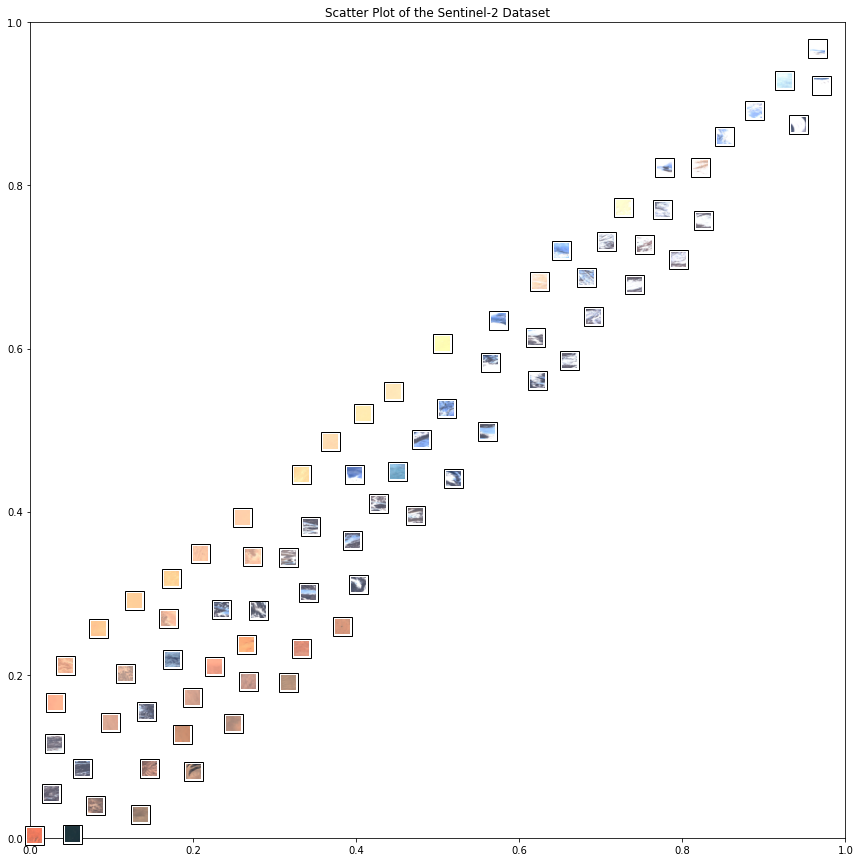

In [35]:
# Initialize empty figure and add subplot.
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)

# Get a scatter plot with thumbnail overlays.
get_scatter_plot_with_thumbnails_axes(
    ax,
    title='Scatter Plot of the Sentinel-2 Dataset'
)

## Nearest Neighbors

### Pick up one random sample per class

In [36]:
# List of subdirectories (classes).
directory_list = []
for root, dirs, files in os.walk(data_dir_test):
    for dirname in sorted(dirs):
        directory_list.append(os.path.join(root, dirname))
        # print(dirname)

In [37]:
# List of files (samples).
example_images = []
for classes in directory_list:

    # Random samples.
    random_file = np.random.choice(os.listdir(classes))
    path_to_random_file = classes + '/' + random_file

    # Only class and filename.
    start_chr = path_to_random_file.index('test/') + 5

    # Append filename.
    example_images.append(path_to_random_file[start_chr:])
    # print(example_images)

### Look for similar images

In [38]:
def get_image_as_np_array(filename: str):
    """
    Loads the image with filename and returns it as a numpy array.

    """
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """
    Returns an image as a numpy array with a black frame of width w.

    """
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape

    # Create an empty image with padding for the frame.
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)

    # Put the original image in the middle of the new one.
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_nxn(example_image: str, i: int):
    """
    Plots the example image and its eight nearest neighbors.

    """
    n_subplots = 6

    # Initialize empty figure.
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")

    # Get indexes.
    example_idx = filenames.index(example_image)

    # Get distances to the cluster center.
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()

    # Sort indices by distance to the center.
    nearest_neighbors = np.argsort(distances)[:n_subplots]

    # Show images.
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)

        # Get the corresponding filename.
        fname = os.path.join(data_dir_test, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))

        # Let's disable the axis.
        plt.axis("off")

/tmp/ipykernel_69224/1966133675.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 10))


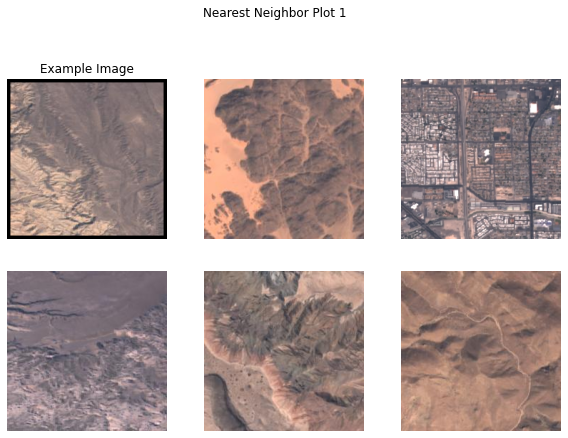

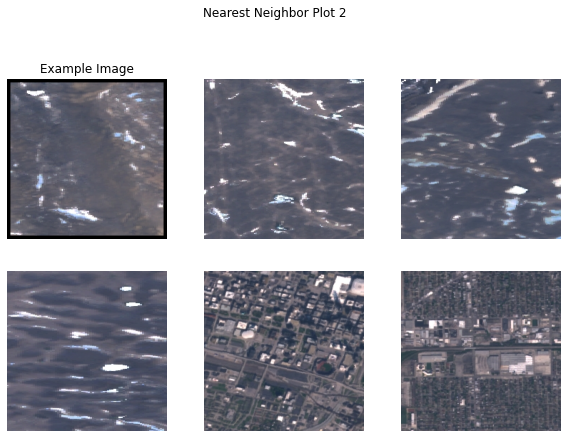

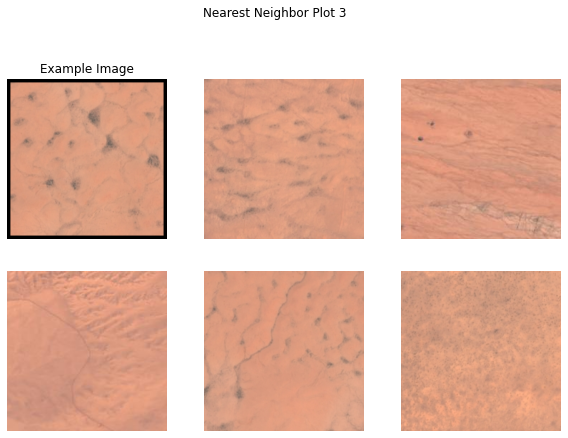

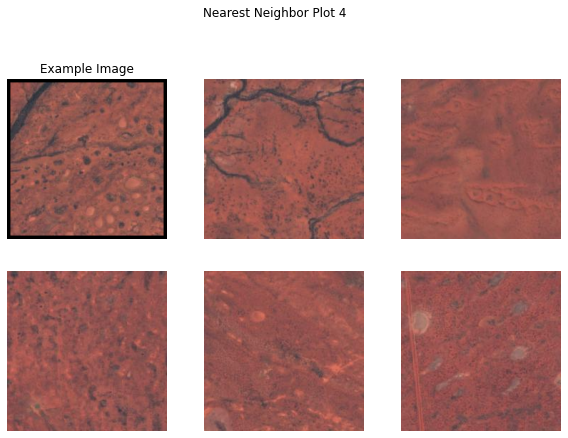

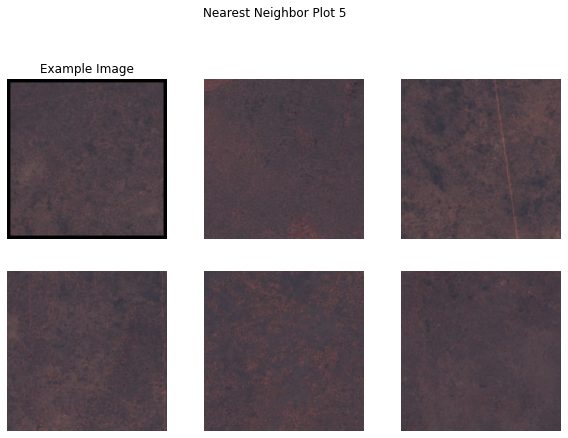

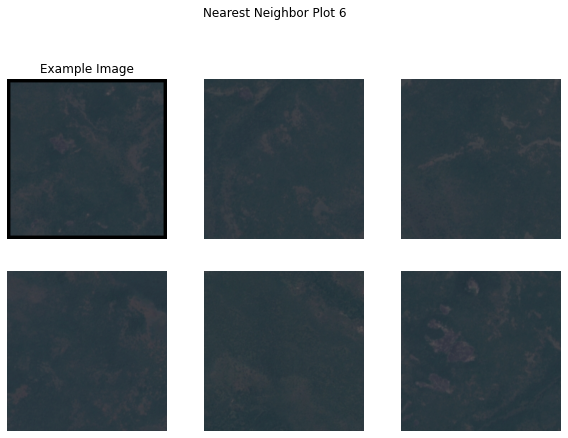

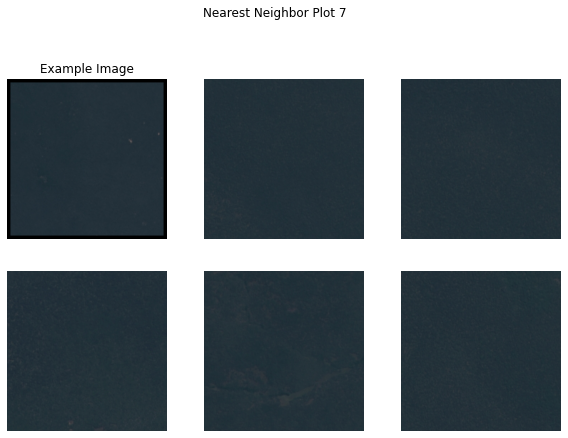

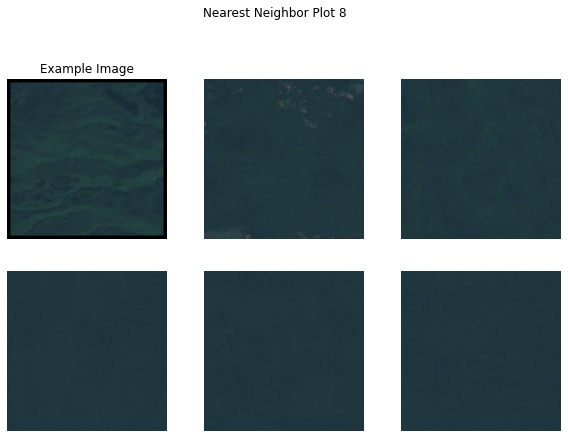

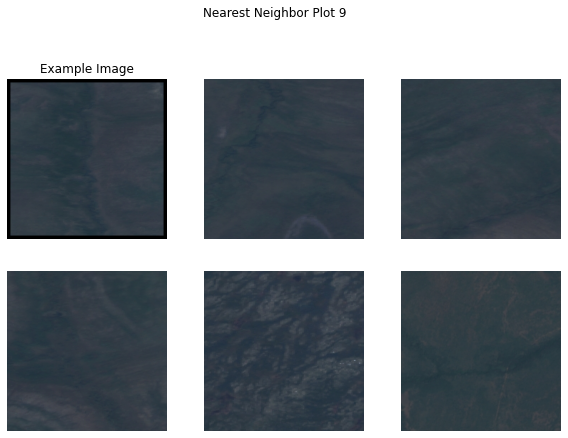

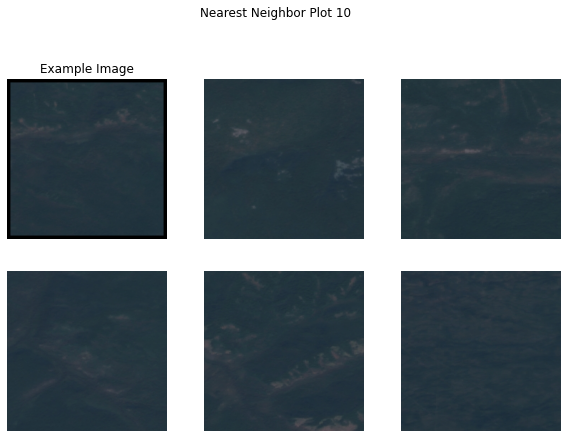

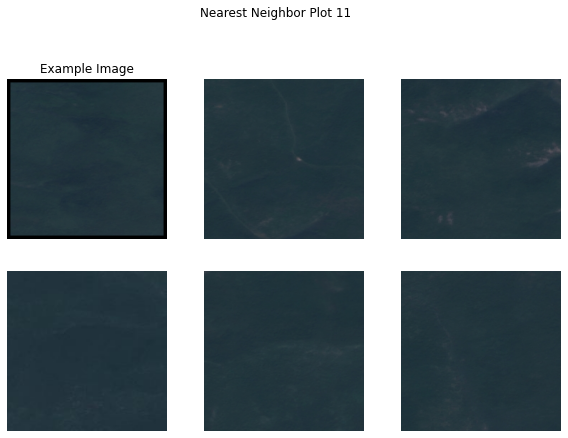

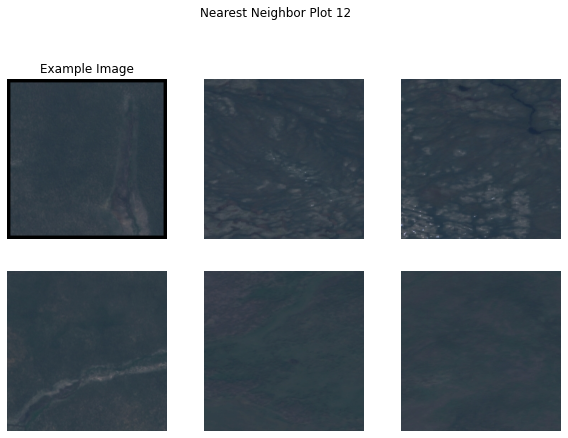

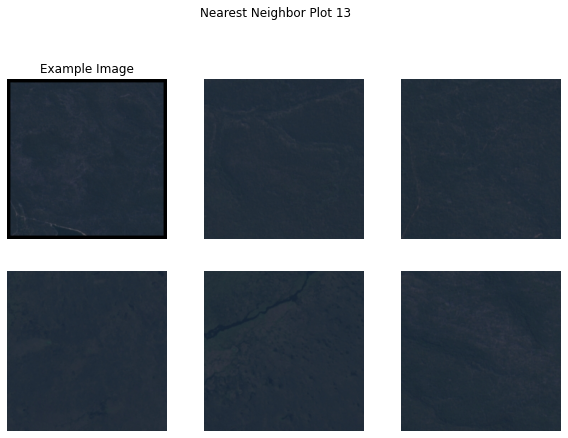

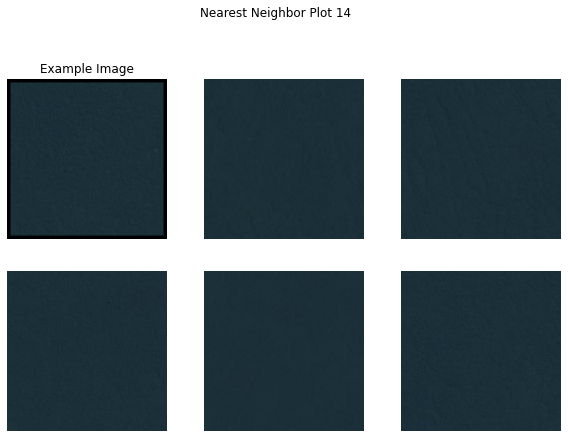

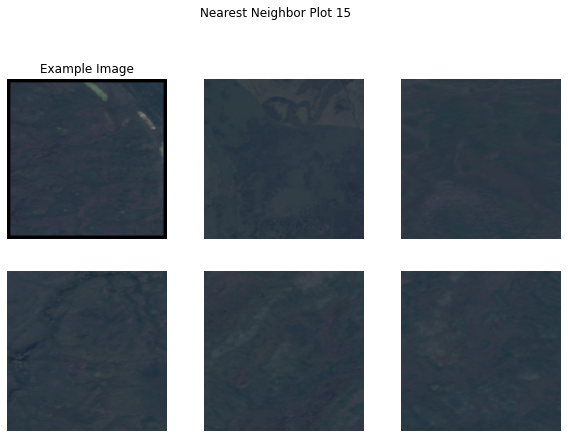

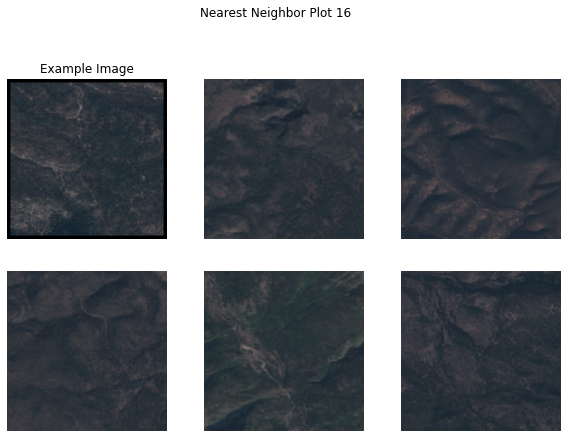

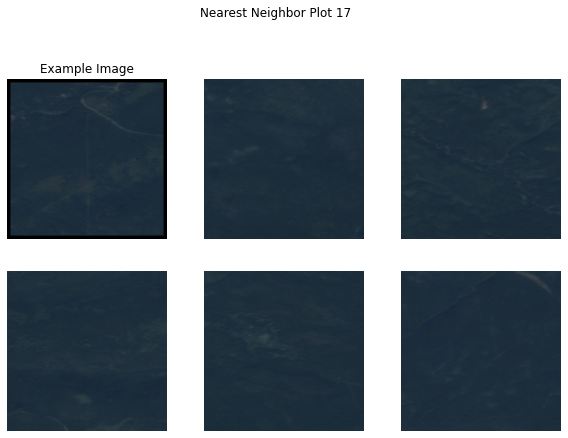

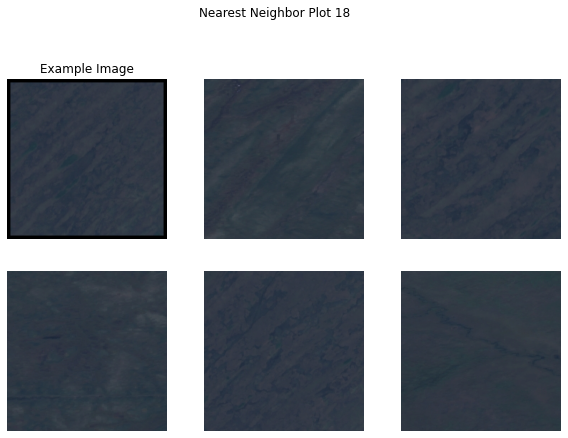

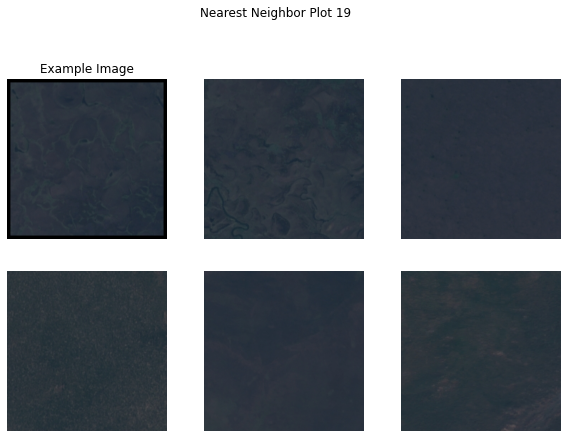

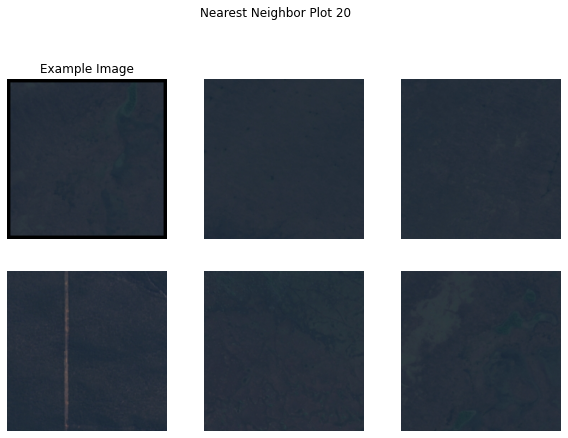

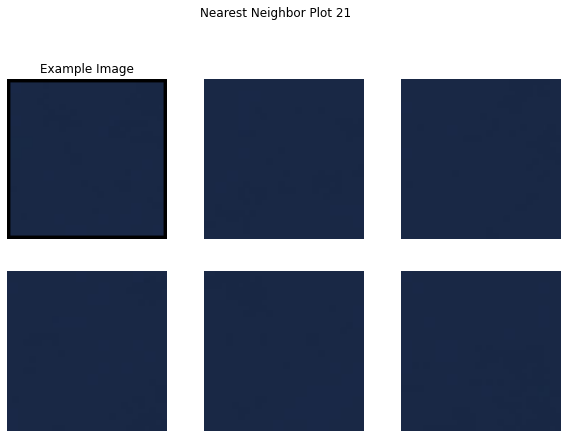

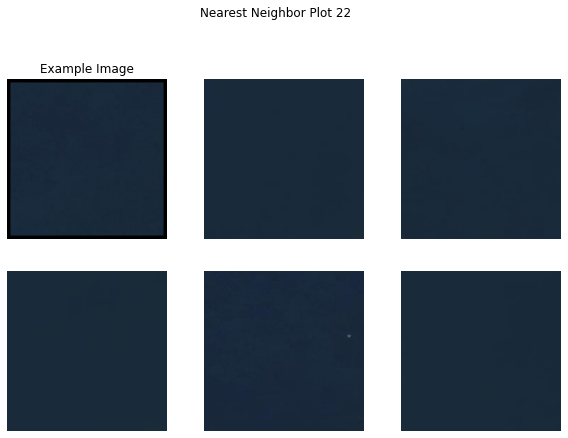

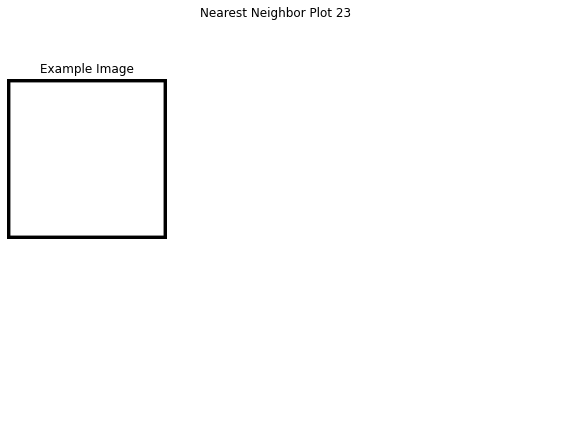

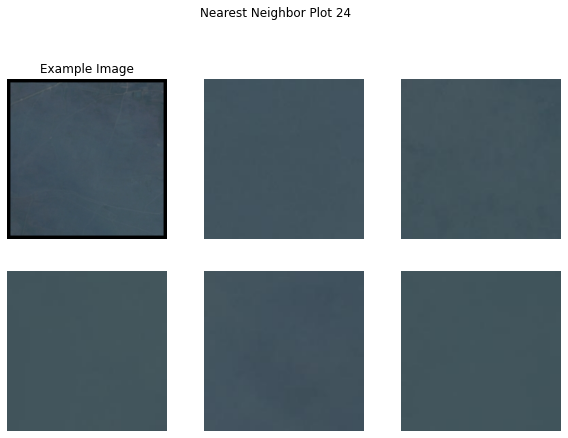

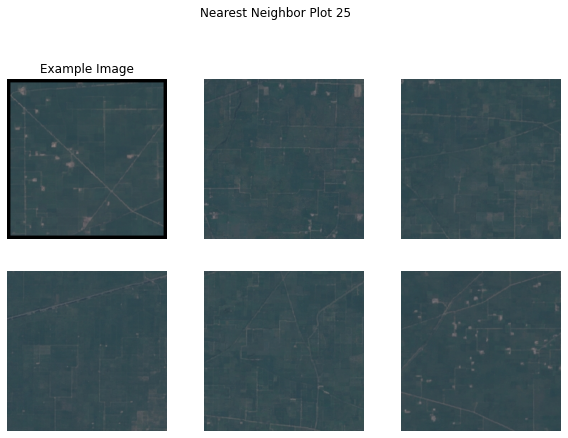

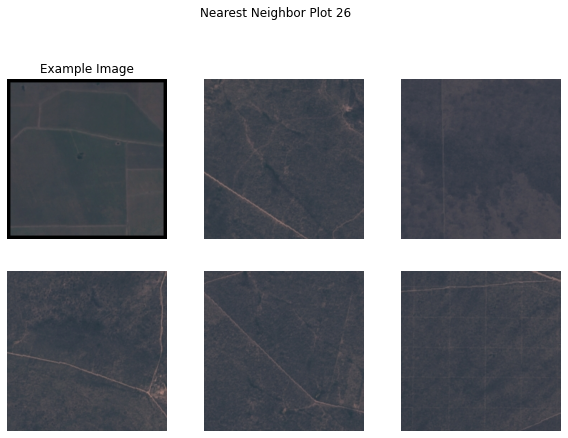

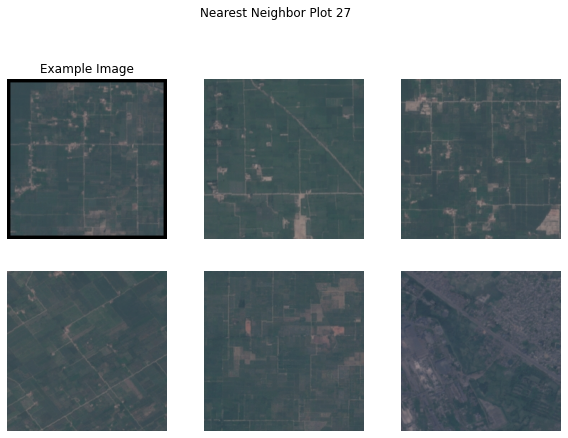

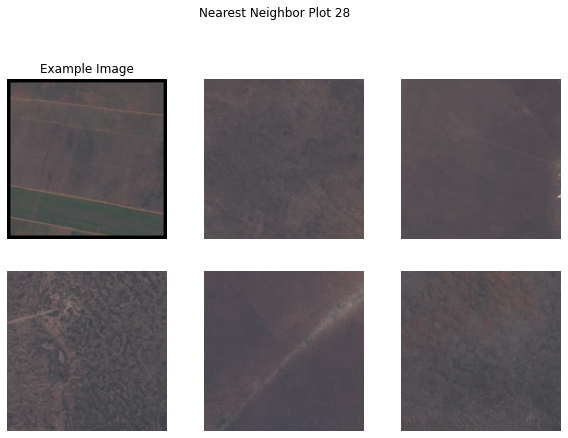

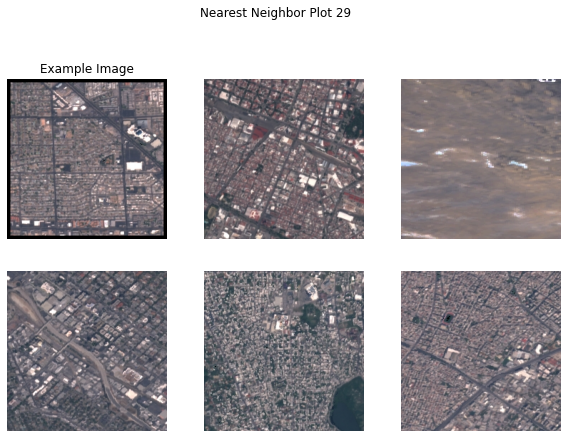

In [39]:
# Show example images for each cluster.
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_nxn(example_image, i)